In [ ]:
!pip install gcsfs
!pip install google-cloud-bigquery
!pip install db-dtypes
!pip install opencv-python-headless
!pip install opencv-python
!pip install pytorch-msssim
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 78.5 MB/s eta 0:00:00a 0:00:01
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 74.1 MB/s eta 0:00:00a 0:00:01
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 63.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: typing-ex

In [8]:
# IMPORT PACKAGES
from google.cloud import storage
from google.cloud import bigquery
import gcsfs
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import re
from PIL import Image
import io
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from pytorch_msssim import ssim
import os

In [9]:
def get_image_path(folder,bucket):

    # Expresión regular para detectar imágenes (extensiones comunes: jpg, jpeg, png, gif, etc.)
    image_pattern = re.compile(r'.*\.(jpg|jpeg|png|gif)$', re.IGNORECASE)

    # Obtener los blobs que pertenecen a la carpeta origen
    blobs = bucket.list_blobs(prefix=folder)

    # Lista para almacenar los paths de las imágenes
    lista_imagenes = []

    # Recorrer los blobs y agregar los paths de las imágenes a la lista
    for blob in blobs:
        if image_pattern.match(blob.name):
            #path_completo = f"gs://{bucket_name}/{blob.name}"
            lista_imagenes.append(blob.name)

    return lista_imagenes

In [10]:
image_folder = 'all_stimuli/'
heatmap_folder = 'all_fixation/'

# Ruta de la carpeta
carpeta = "/Users/juanjosilva/Desktop/Tesis/storage/"

# Listar todos los archivos y carpetas en la ruta
image_path = os.listdir(carpeta + image_folder)
heatmap_path = os.listdir(carpeta + heatmap_folder)

image_path = [os.path.join((carpeta + image_folder), archivo) for archivo in image_path]
heatmap_path = [os.path.join((carpeta + heatmap_folder), archivo) for archivo in heatmap_path]

print(len(heatmap_path))
print(len(image_path))
print(image_path)
print(heatmap_path)

2000
2000
['/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/object_125.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/affective_019.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/object_131.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/lowresolution_197.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/object_119.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/affective_025.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/affective_031.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/lowresolution_183.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/inverted_003.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/indoor_179.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/inverted_017.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/indoor_145.jpg', '/Users/juanjosilva/Desktop/Tesis/storage/all_stimuli/indoor_151.jpg', '/Users/juanjosilva/Desktop/Tesis/stora

In [ ]:
num_epochs = 20
learning_rate = 0.001
batch_size = 32

In [ ]:
color_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

gray_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=3),  # Convertir escala de grises a 3 canales
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])  # Usar las mismas estadísticas de RGB
])

heatmap_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class CustomDataset(Dataset):
    def __init__(self, image_paths, heatmap_paths, image_transform=None, gray_transform=None, heatmap_transform=None):
        self.image_paths = image_paths
        self.heatmap_paths = heatmap_paths
        self.image_transform = image_transform
        self.gray_transform = gray_transform
        self.heatmap_transform = heatmap_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.load_image(self.image_paths[idx])  # No se convierte a RGB aquí
        heatmap = self.load_image(self.heatmap_paths[idx])  # Mapa de calor en escala de grises

        # Si la imagen es en escala de grises (1 canal), la transformamos usando gray_transform
        if image.mode == 'L':  # Imagen en escala de grises
            image = self.gray_transform(image)  # Usamos gray_transform para convertir a 3 canales (RGB) y normalizar
        else:
            image = self.image_transform(image)  # Imagen RGB normal, aplicamos el transform de color

        heatmap = self.heatmap_transform(heatmap)
        #print(f'Heatmap shape: {heatmap.shape}') # Para los mapas de calor también se transforma como en escala de grises

        return image, heatmap


    def load_image(self, file_path):
        """Carga una imagen desde una carpeta local"""
        # Verifica que el archivo existe
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"El archivo {file_path} no existe.")

        # Abrir la imagen con PIL
        image = Image.open(file_path)
        return image

dataset = CustomDataset(image_path, heatmap_path, image_transform = color_transform, gray_transform = gray_transform, heatmap_transform = heatmap_transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        # Cargar el modelo ResNet preentrenado
        self.resnet = models.resnet34()  # Puedes elegir otros modelos como resnet18, resnet50, etc.

        # Modificar la capa de entrada para aceptar imágenes con 3 canales
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Codificador (resnet)
        self.encoder = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            # ResNet layers
            self.resnet.layer1, 
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4,
        )

        # Decodificador
        self.upconv4 = self.upconv_block(512, 256)  # Capa de transposición para la cuarta capa
        self.upconv3 = self.upconv_block(256, 128)  # Capa de transposición para la tercera capa
        self.upconv2 = self.upconv_block(128, 64)   # Capa de transposición para la segunda capa
        self.upconv1 = self.upconv_block(64, 64)    # Capa de transposición para la primera capa

        # Final layer para obtener la salida (mapa de calor)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=(1, 1))

    def upconv_block(self, in_channels, out_channels):
        """Bloque de decodificación con upsampling y convolución"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Codificador: Propagación a través del ResNet
        enc1 = self.encoder[0:4](x)  # Capa inicial
        enc2 = self.encoder[4](enc1)  # Capa layer1
        enc3 = self.encoder[5](enc2)  # Capa layer2
        enc4 = self.encoder[6](enc3)  # Capa layer3
        enc5 = self.encoder[7](enc4)  # Capa layer4

        # Decodificador: Propagación a través del upsampling
        dec4 = self.upconv4(enc5)
        dec3 = self.upconv3(dec4)
        dec2 = self.upconv2(dec3)
        dec1 = self.upconv1(dec2)

        # Ajuste para obtener dimensiones correctas: upsampling adicional si es necesario
        dec1 = F.interpolate(dec1, size=(256, 256), mode='bilinear', align_corners=True)

        # Generamos la salida final
        out = self.final_conv(dec1)
        return out


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando GPU MPS para entrenamiento")
else:
    device = torch.device("cpu")
    print("Usando CPU para entrenamiento")

print(f"Using device: {device}")

Usando GPU MPS para entrenamiento


In [ ]:
model = UNet(in_channels=3, out_channels=1)  
model = model.to(device)

# Definir la función de pérdida
criterion = nn.MSELoss()

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_list = []

for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        results_list.append({'Epoch': epoch + 1, 'Step': i + 1, 'Loss': loss.item()})

        # Imprimir la pérdida cada cierto número de iteraciones
        if (i+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.6f}')


# Convertir la lista en un DataFrame
results = pd.DataFrame(results_list)

# Guardar en CSV (opcional)
results.to_csv('/Users/juanjosilva/Desktop/Tesis/models/resultados_entrenamiento.csv', index=False)
torch.save(model, '/Users/juanjosilva/Desktop/Tesis/models/modelo_atencion_visual.pth')

Using device: mps
Epoch [1/20], Step [5/32], Loss: 0.196424
Epoch [1/20], Step [10/32], Loss: 0.865505
Epoch [1/20], Step [15/32], Loss: 0.970319
Epoch [1/20], Step [20/32], Loss: 0.950707
Epoch [1/20], Step [25/32], Loss: 0.914191
Epoch [1/20], Step [30/32], Loss: 0.844124
Epoch [2/20], Step [5/32], Loss: 0.204145
Epoch [2/20], Step [10/32], Loss: 0.107080
Epoch [2/20], Step [15/32], Loss: 0.072904
Epoch [2/20], Step [20/32], Loss: 0.058399
Epoch [2/20], Step [25/32], Loss: 0.057374
Epoch [2/20], Step [30/32], Loss: 0.052738
Epoch [3/20], Step [5/32], Loss: 0.045962
Epoch [3/20], Step [10/32], Loss: 0.046343
Epoch [3/20], Step [15/32], Loss: 0.042739
Epoch [3/20], Step [20/32], Loss: 0.040604
Epoch [3/20], Step [25/32], Loss: 0.041250
Epoch [3/20], Step [30/32], Loss: 0.036470
Epoch [4/20], Step [5/32], Loss: 0.038876
Epoch [4/20], Step [10/32], Loss: 0.033210
Epoch [4/20], Step [15/32], Loss: 0.031369
Epoch [4/20], Step [20/32], Loss: 0.031972
Epoch [4/20], Step [25/32], Loss: 0.0333

In [79]:
def denormalize_heatmap(tensor, mean=0.5, std=0.5):
    """
    Desnormaliza un tensor de heatmap.
    
    Args:
        tensor (torch.Tensor): El tensor normalizado.
        mean (float): La media utilizada para normalizar.
        std (float): La desviación estándar utilizada para normalizar.

    Returns:
        torch.Tensor: Tensor desnormalizado en el rango original.
    """
    return tensor * std + mean

In [89]:

def heatmap_prediction(model, path_image, path_output_heatmap):

  imagen = Image.open(path_image).convert('RGB')
  imagen = color_transform(imagen).unsqueeze(0)  # Añadir batch dimension

  model = model.to('cpu')
  model.eval()
  with torch.no_grad():
    predicted_heatmap = model(imagen)
    predicted_heatmap_denormalized = denormalize_heatmap(predicted_heatmap, mean=0.5, std=0.5)
    # Verifica y maneja valores no válidos
    print("Min value:", predicted_heatmap_denormalized.min())
    print("Max value:", predicted_heatmap_denormalized.max())
    print("Contains NaN:", torch.isnan(predicted_heatmap_denormalized).any())
    print("Contains Inf:", torch.isinf(predicted_heatmap_denormalized).any())

    # Maneja NaN, Inf y clampa los valores
    predicted_heatmap_denormalized = torch.nan_to_num(predicted_heatmap_denormalized, nan=0.0, posinf=1.0, neginf=0.0)
    predicted_heatmap_clamped = predicted_heatmap_denormalized.clamp(0, 1)
    # Guardar el heatmap en el bucket con un nuevo nombre
    heatmap_filename = path_image.split('/')[-1].replace('.png', '_heatmap.png')  # Cambiar extensión
    print(heatmap_filename)
    heatmap_save = path_output_heatmap + heatmap_filename
    predicted_heatmap_img = transforms.ToPILImage()(predicted_heatmap_clamped.squeeze(0))
    predicted_heatmap_img.save(heatmap_save, format='PNG')
    #plt.imshow(predicted_heatmap_img, cmap='coolwarm')  # Si es un mapa de calor
    #plt.colorbar()
    #plt.show()
  
  return heatmap_save, heatmap_filename

In [81]:
def opacity_map_rgba(heatmap_save, path_image, heatmap_filename, opacity_path):
    
    # Abrir las imágenes
    mapa_calor = Image.open(heatmap_save)
    imagen_original = Image.open(path_image)

    # Convertir de PIL a formato OpenCV (RGB -> BGR)
    imagen_original = cv2.cvtColor(np.array(imagen_original), cv2.COLOR_RGB2BGR)
    mapa_calor = cv2.cvtColor(np.array(mapa_calor), cv2.COLOR_RGB2BGR)

    # Obtener las dimensiones de la imagen original
    height, width, channels = imagen_original.shape
    print(f"Width: {width}, Height: {height}, Channels: {channels}")

    # Convertir el mapa de calor a escala de grises
    mapa_calor = cv2.cvtColor(mapa_calor, cv2.COLOR_BGR2GRAY)

    # Normalizar el mapa de calor entre 0 y 1
    mapa_calor_normalizado = cv2.normalize(mapa_calor, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Acentuar las zonas de baja intensidad usando una transformación
    potencia = 0.5  # Ajusta este valor según el nivel de relevancia deseado
    mapa_calor_acentuado = np.power(mapa_calor_normalizado, potencia)
    mapa_calor_acentuado = cv2.normalize(mapa_calor_acentuado, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # Redimensionar el mapa de calor acentuado al tamaño de la imagen original
    mapa_calor_redimensionado = cv2.resize(mapa_calor_acentuado, (width, height))

    # Crear un fondo negro del mismo tamaño que la imagen original
    fondo_negro = np.zeros_like(imagen_original, dtype=np.uint8)

    # Crear el mapa de opacidad RGB
    mapa_opacidad_rgb = (
        (mapa_calor_redimensionado[..., np.newaxis] * imagen_original) +
        ((1 - mapa_calor_redimensionado[..., np.newaxis]) * fondo_negro)
    ).astype(np.uint8)

    # Generar el canal alfa basado en el mapa de calor normalizado
    alpha_channel = (mapa_calor_redimensionado * 255).astype(np.uint8)

    # Combinar los canales RGB y alfa para crear una imagen RGBA
    mapa_opacidad_rgba = cv2.merge(( 
        mapa_opacidad_rgb[:, :, 0],  # Canal R
        mapa_opacidad_rgb[:, :, 1],  # Canal G
        mapa_opacidad_rgb[:, :, 2],  # Canal B
        alpha_channel               # Canal A (transparencia)
    ))

    # Guardar la imagen RGBA
    ruta_guardar_imagen = opacity_path + heatmap_filename
    cv2.imwrite(ruta_guardar_imagen, mapa_opacidad_rgba)

    print(f"Mapa de opacidad RGBA guardado en: {ruta_guardar_imagen}")


In [101]:
def opacity_map(heatmap_save, path_image, heatmap_filename, opacity_path):

    mapa_calor = Image.open(heatmap_save)
    imagen_original = Image.open(path_image)

    # Convertir de PIL a formato OpenCV (RGB -> BGR)
    imagen_original = cv2.cvtColor(np.array(imagen_original), cv2.COLOR_RGB2BGR)
    mapa_calor = cv2.cvtColor(np.array(mapa_calor), cv2.COLOR_RGB2BGR)

    # Obtener las dimensiones de la imagen original
    height, width, channels = imagen_original.shape
    print(f"Width: {width}, Height: {height}, Channels: {channels}")

    # Convertir el mapa de calor a escala de grises
    mapa_calor = cv2.cvtColor(mapa_calor, cv2.COLOR_BGR2GRAY)

    # Normalizar el mapa de calor entre 0 y 1
    mapa_calor_normalizado = cv2.normalize(mapa_calor, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Acentuar las zonas de baja intensidad usando una transformación
    # Ejemplo: elevar a una potencia < 1 para amplificar valores pequeños
    potencia = 0.5 # Ajusta este valor según el nivel de relevancia deseado
    mapa_calor_acentuado = np.power(mapa_calor_normalizado, potencia)
    mapa_calor_acentuado = cv2.normalize(mapa_calor_acentuado, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # Redimensionar el mapa de calor acentuado al tamaño de la imagen original
    mapa_calor_redimensionado = cv2.resize(mapa_calor_acentuado, (width, height))

    # Crear un fondo negro del mismo tamaño que la imagen original
    fondo_negro = np.zeros_like(imagen_original, dtype=np.uint8)

    # Crear el mapa de opacidad
    mapa_opacidad = (
        (mapa_calor_redimensionado[..., np.newaxis] * imagen_original) +
        ((1 - mapa_calor_redimensionado[..., np.newaxis]) * fondo_negro)
    ).astype(np.uint8)

    # Guardar la imagen generada en la ubicación especificada
    ruta_guardar_imagen = opacity_path + heatmap_filename
    cv2.imwrite(ruta_guardar_imagen, mapa_opacidad)


In [ ]:
def heatmap_opacity_map (model, folder, media):

    opacity_path = folder + media + '/opacity_map/'
    path_output_heatmap = folder + media + '/heatmap_prediction/'

    exterior_path = os.listdir(folder + media + '/image_original/')
    exterior_path = [
        os.path.join(folder + media + '/image_original/', archivo) 
        for archivo in exterior_path 
        if archivo.lower().endswith('.png')
    ]
    print(exterior_path)
    for image in exterior_path:

        heatmap_save, heatmap_filename = heatmap_prediction(model, image, path_output_heatmap)
        opacity_map(heatmap_save, image, heatmap_filename, opacity_path)

In [107]:
folder = "/Users/juanjosilva/Desktop/Tesis/storage/"
heatmap_opacity_map (model, folder, 'exterior')
heatmap_opacity_map (model, folder, 'digital')

['/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/gillete.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/abanca.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/ikea.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/narciso.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/mutua.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/ing.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/pantene.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/estrellagalicia.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/vodafone.png', '/Users/juanjosilva/Desktop/Tesis/storage/exterior/image_original/ecoembesred.png']
Min value: tensor(-0.0273)
Max value: tensor(0.6959)
Contains NaN: tensor(False)
Contains Inf: tensor(False)
gillete_heatmap.png
Width: 912, Height: 1349, Channels: 3
Min value: tensor(-0.0190)
Ma

In [108]:
from skimage.metrics import mean_squared_error, structural_similarity
import numpy as np
from PIL import Image

map1 = '/Users/juanjosilva/Desktop/Tesis/storage/exterior/heatmap_original/Abanca_1  - Opacity map.png'
map2 = '/Users/juanjosilva/Desktop/Tesis/storage/exterior/opacity_map/abanca_heatmap.png'

image1 = np.array(Image.open(map1).convert("RGB"))
image2 = np.array(Image.open(map2))

mse = mean_squared_error(image1, image2)
print("Mean Squared Error:", mse)

hist1 = np.histogram(image1.flatten(), bins=256, range=(0, 256))[0]
hist2 = np.histogram(image2.flatten(), bins=256, range=(0, 256))[0]

# Comparar usando una métrica, como la correlación o la distancia euclidiana
correlation = np.corrcoef(hist1, hist2)[0, 1]
print("Histogram Correlation:", correlation)

Mean Squared Error: 2452.807645617342
Histogram Correlation: 0.023695516086213377


El valor máximo del canal alfa es: 254
El valor minimo del canal alfa es: 0


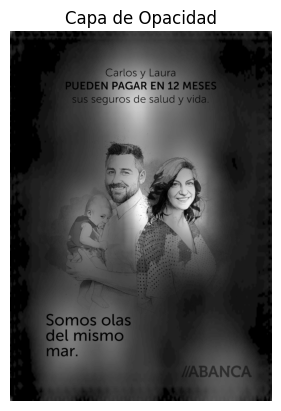

In [109]:
# Extraer la capa de opacidad (canal alfa)
if image2.shape[-1] == 3:
    alpha_channel = image2[..., 1]  # Cuarto canal es la opacidad


    # Visualizar la capa de opacidad
    max_alpha = np.max(alpha_channel)  # Obtener el máximo valor
    print("El valor máximo del canal alfa es:", max_alpha) 
    min_alpha = np.min(alpha_channel)  # Obtener el máximo valor
    print("El valor minimo del canal alfa es:", min_alpha) 
    plt.imshow(alpha_channel, cmap="gray")
    plt.title("Capa de Opacidad")
    plt.axis("off")  # Oculta los ejes
    plt.show()
else:
    print("La imagen no tiene canal alfa.")